



Epoch 1/20


288/288 [==============================] - 1s 3ms/step - loss: 0.3414 - accuracy: 0.8331 - val_loss: 0.2940 - val_accuracy: 0.8570
Epoch 2/20
288/288 [==============================] - 1s 2ms/step - loss: 0.2902 - accuracy: 0.8603 - val_loss: 0.2863 - val_accuracy: 0.8596
Epoch 3/20
288/288 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.8597 - val_loss: 0.2808 - val_accuracy: 0.8591
Epoch 4/20
288/288 [==============================] - 0s 2ms/step - loss: 0.2770 - accuracy: 0.8659 - val_loss: 0.2808 - val_accuracy: 0.8635
Epoch 5/20
288/288 [==============================] - 0s 2ms/step - loss: 0.2728 - accuracy: 0.8667 - val_loss: 0.2709 - val_accuracy: 0.8683
Epoch 6/20
288/288 [==============================] - 0s 2ms/step - loss: 0.2676 - accuracy: 0.8701 - val_loss: 0.2672 - val_accuracy: 0.8665
Epoch 7/20
288/288 [==============================] - 0s 2ms/step - loss: 0.2634 - accuracy: 0.8752 - val_loss: 0.2643 - val_accuracy: 0.8691


INFO:tensorflow:Assets written to: C:\Users\Windows\AppData\Local\Temp\tmp17pzjjga\assets



Original Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 3)         51        
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 3)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 432)               0         
                                                                 
 dense (Dense)               (None, 1)                 433       
                                                                 
Total params: 484 (1.89 KB)
Trainable params: 484 (1.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Quantized Model Summary:
Model: "sequential"
_____________________

c:\Users\Windows\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Average Inference Time: 2.0015239715576173e-05 seconds
72/72 [==============================] - 0s 1ms/step - loss: 0.6701 - accuracy: 0.7565

Test accuracy (quantized model): 0.7565217614173889


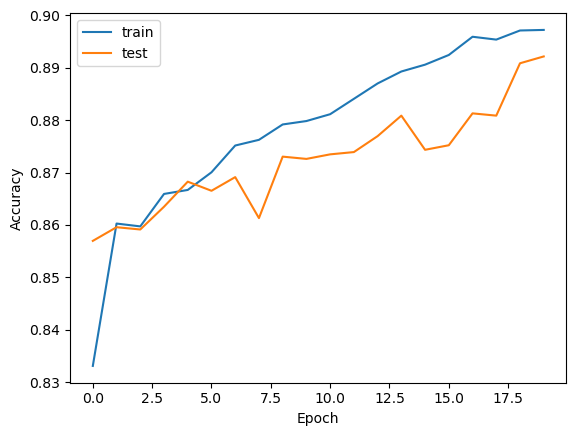

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow_model_optimization.quantization.keras import quantize_model
import time  # Import the time module for performance measurement

# Load the dataset
data = pd.read_csv(r'C:\Users\Windows\Downloads\archive\2_character_TMNIST.csv')  # Update the path to your dataset file

# Separate data into features (X) and labels (y)
X = data.drop(columns=['names', 'labels'])
y = data['labels']

# Convert 'X' and 'O' labels to binary values (1 for 'X' and 0 for 'O')
y_binary = (y == 'X').astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

# Normalize the data
X_train, X_test = X_train / 255.0, X_test / 255.0

# Convert grayscale to binary
X_train_binary = (X_train > 0.05).astype(float)
X_test_binary = (X_test > 0.05).astype(float)

# Create a CNN model
model = Sequential()
model.add(Conv2D(3, (4, 4), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for more epochs
history = model.fit(X_train_binary, y_train, epochs=20, validation_data=(X_test_binary, y_test))

# Quantize the model
quantized_model = quantize_model(model)

# Compile the quantized model
quantized_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert the model to TensorFlow Lite with int8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Define a representative dataset
def representative_dataset():
    for input_data in tf.data.Dataset.from_tensor_slices(X_train_binary.astype(np.float32)).batch(1).take(100):
        yield [input_data]

converter.representative_dataset = representative_dataset

# Convert the model to TensorFlow Lite
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('quantized_model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

# Display model summary for the original model
print("\nOriginal Model Summary:")
model.summary()

# Display model summary for the quantized model
print("\nQuantized Model Summary:")
quantized_model.summary()

# Display performance summary
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Warm-up the model
for _ in range(10):
    interpreter.invoke()

# Measure inference time
start_time = time.time()
for _ in range(100):
    interpreter.invoke()
inference_time = (time.time() - start_time) / 100  # Average inference time per iteration

# Display performance summary
print(f'\nAverage Inference Time: {inference_time} seconds')

# Evaluate the quantized model
test_loss, test_accuracy = quantized_model.evaluate(X_test_binary, y_test)
print(f'\nTest accuracy (quantized model): {test_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Tfmodel

In [3]:
# Display model weights and parameters for the quantized model
print("\nQuantized Model Weights and Parameters:")
for layer in quantized_model.layers:
    if hasattr(layer, 'get_weights'):
        weights = layer.get_weights()
        if weights:
            print(f"\nLayer: {layer.name}")
            for i in range(len(weights)):
                quantized_values = np.int8(weights[i] * 127).tolist()
                print(f"Quantized Weight {i + 1} shape: {weights[i].shape}")
                print(quantized_values)



Quantized Model Weights and Parameters:

Layer: quantize_layer
Quantized Weight 1 shape: ()
0
Quantized Weight 2 shape: ()
0
Quantized Weight 3 shape: ()
-127

Layer: quant_conv2d
Quantized Weight 1 shape: (4, 4, 1, 3)
[[[[-53, -35, 31]], [[43, -17, 2]], [[-53, 49, -47]], [[-83, -37, 69]]], [[[-10, -93, 64]], [[11, 49, 16]], [[-26, 88, -4]], [[72, -40, -83]]], [[[-2, -39, 42]], [[75, 15, 40]], [[55, -3, 66]], [[-36, 22, -50]]], [[[-24, 74, 3]], [[62, 76, -59]], [[39, -59, 69]], [[26, 21, 18]]]]
Quantized Weight 2 shape: (3,)
[10, 0, 0]
Quantized Weight 3 shape: ()
-127
Quantized Weight 4 shape: (3,)
[6, 6, 6]
Quantized Weight 5 shape: (3,)
[-6, -6, -6]
Quantized Weight 6 shape: ()
6
Quantized Weight 7 shape: ()
-6

Layer: quant_max_pooling2d
Quantized Weight 1 shape: ()
-127

Layer: quant_flatten
Quantized Weight 1 shape: ()
-127

Layer: quant_dense
Quantized Weight 1 shape: (432, 1)
[[-39], [-46], [-43], [-1], [-18], [10], [-11], [-4], [-38], [0], [-43], [5], [6], [-16], [-30], [0], 

In [4]:
# Rest of your existing code

# Save the output to a text file
output_file_path = 'model_quantization_details.txt'
with open(output_file_path, 'w') as f:
    f.write("\nQuantized Model Weights and Parameters:\n")
    for layer in quantized_model.layers:
        if hasattr(layer, 'get_weights'):
            weights = layer.get_weights()
            if weights:
                f.write(f"\nLayer: {layer.name}\n")
                for i in range(len(weights)):
                    quantized_values = np.int8(weights[i] * 127).tolist()
                    f.write(f"Quantized Weight {i + 1} shape: {weights[i].shape}\n")
                    f.write(str(quantized_values) + "\n")

# Display a message indicating the file path
print(f"Quantization details have been saved to: {output_file_path}")


Quantization details have been saved to: model_quantization_details.txt
